## Examples from "Chiral discrimination in helicity-preserving Fabry-Pérot cavities"

## Import modules

In [1]:
import transfermat_scatt as ts 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle

## Colorbar for the plots

In [2]:
plt.rc('image',cmap='inferno')

In [3]:
col1 = plt.cm.ocean(np.linspace(0,1,64))  # run only once 
col2 = plt.cm.PuOr_r(np.linspace(0.5,1,64))
plt.colormaps.register(mpl.colors.LinearSegmentedColormap.from_list('oceanPu', np.r_[col1,col2]))

## Dielectric permeability $\varepsilon$ 

In [4]:
def eps_DL(omega, epsinf, omegap, omega0=0, gamma=0):
    """Drude-Lorentz model for the dielectric function of a material."""
    eps = epsinf + omegap**2 / (omega0**2 - omega**2 - 1j * gamma * omega)
    return eps

## Calculations for Fig.2 and Fig.4 (see in Erratum Fig.1 and Fig.2)

In [5]:
omegap = np.linspace(0, 1, 401)
omega  = np.linspace(1.65, 2.2, 2400)[:,None]
kappa  = np.linspace(0, -1e-3, 2)[:,None,None]
icut_omp = np.argmin(abs(omegap-0.2))
assert omegap[icut_omp] == 0.2

eps_Ag  = eps_DL(omega, epsinf=4.77574276, omegap=9.48300763, omega0=0,   gamma=0.17486845)
eps_mol = eps_DL(omega, epsinf=2.89,       omegap=omegap,     omega0=1.9, gamma=0.1)

air_infty = ts.MaterialLayer(d=np.inf, eps=1)
air_thin  = ts.MaterialLayer(d=0,      eps=1)
Ag_mirror = ts.MaterialLayer(d=16,     eps=eps_Ag)
molecules = ts.MaterialLayer(d=130,    eps=eps_mol, kappa=kappa)

omegaPR = 2
gammaPR = 0.05
mirror_1 = ts.helicity_preserving_mirror(omega,omegaPR=omegaPR,gammaPR=gammaPR,enantiomer=False)
mirror_2 = ts.helicity_preserving_mirror(omega,omegaPR=omegaPR,gammaPR=gammaPR,enantiomer=True)

S_Ag = ts.TScat([air_infty, Ag_mirror,          molecules, Ag_mirror,          air_infty], omega, theta0=0.)
S_HP = ts.TScat([air_infty, mirror_1, air_thin, molecules, air_thin, mirror_2, air_infty], omega, theta0=0.)

S_HP.ΔDCTs = S_HP.DCTs[1] - S_HP.DCTs[0]
S_Ag.ΔDCTs = S_Ag.DCTs[1] - S_Ag.DCTs[0]

In [6]:
# make this a function to avoid overwriting the global variables with the "main" results
def tmp(omega,omegap):
    icut = abs(omegap - 0.05).argmin()
    imax = S_HP.ΔDCTs[:,icut].argmax()
    print(omega.squeeze()[imax],omegap[icut])

    omegap = 0.05
    omega = omega[imax]
    kappa = np.linspace(-1e-3,1e-3,51)
    ikappa0 = np.argmin(abs(kappa))
    assert kappa[ikappa0] == 0

    eps_mol = eps_DL(omega, epsinf=2.89, omegap=omegap, omega0=1.9, gamma=0.1)
    air_infty = ts.MaterialLayer(d=np.inf, eps=1)
    air_thin  = ts.MaterialLayer(d=0,      eps=1)
    molecules = ts.MaterialLayer(d=130,    eps=eps_mol, kappa=kappa)
    mirror_1 = ts.helicity_preserving_mirror(omega,omegaPR=omegaPR,gammaPR=gammaPR,enantiomer=False)
    mirror_2 = ts.helicity_preserving_mirror(omega,omegaPR=omegaPR,gammaPR=gammaPR,enantiomer=True)
    S = ts.TScat([air_infty, mirror_1, air_thin, molecules, air_thin, mirror_2, air_infty], omega, theta0=0.)
    S.kappa = kappa
    S.ΔDCTs = S.DCTs - S.DCTs[ikappa0]
    return S

S_kappascan = tmp(omega,omegap)

1.964776990412672 0.05


## Plot of Fig.2 (see in Erratum Fig.1)

In [7]:
def Es2x2(E1,E2,g):
    Em = (E1+E2)/2
    sq = np.sqrt((E1-E2)**2/4 + g**2)
    return np.array([Em-sq, Em+sq])

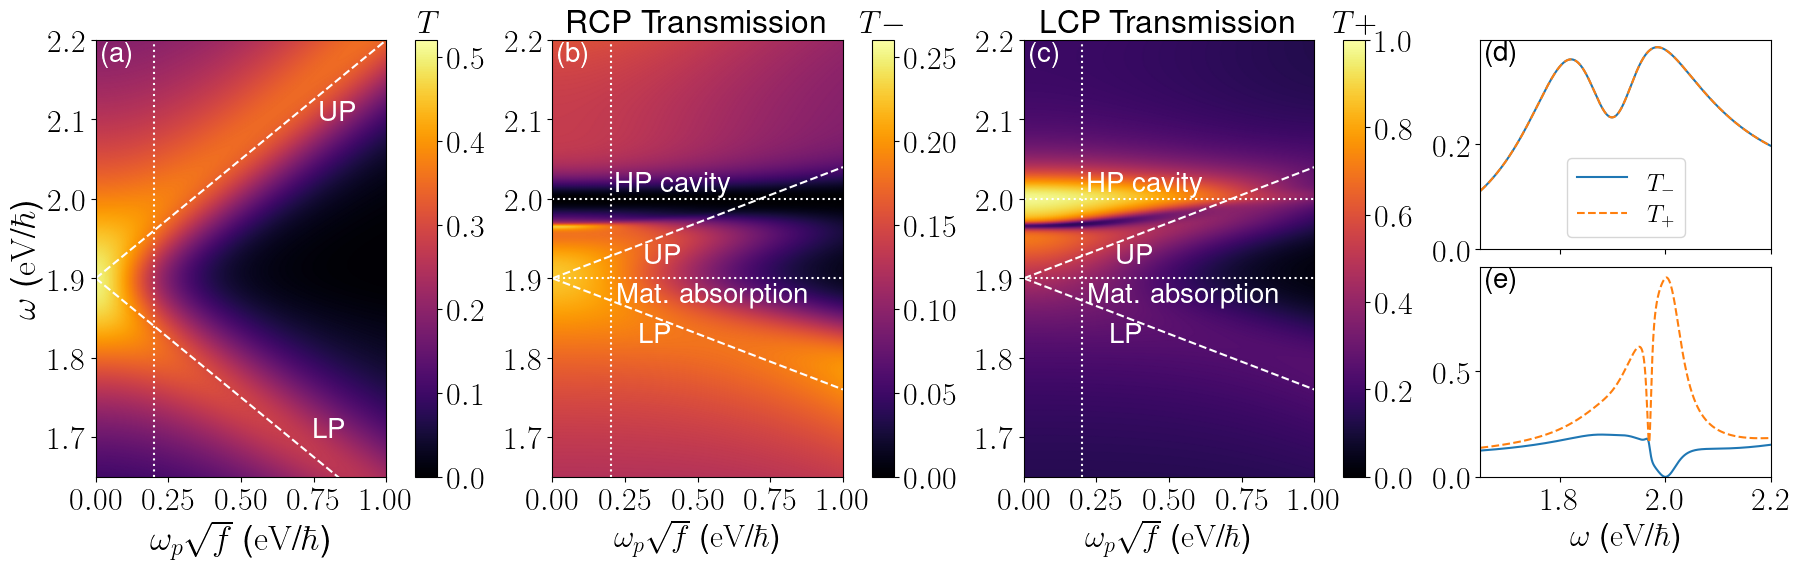

In [9]:
fig, axs = plt.subplot_mosaic("""abcd
                                 abce""",layout="constrained",figsize=(18,5.5))

plt.rcParams.update({ "text.usetex": True, "font.family": "Helvetica"})
axs["a"].tick_params(axis='both', which='major', labelsize=23)
axs["a"].set_xticks([0,0.25,0.5,0.75,1])
axs["b"].tick_params(axis='both', which='major', labelsize=23)
axs["b"].set_xticks([0,0.25,0.5,0.75,1])
axs["c"].tick_params(axis='both', which='major', labelsize=23)
axs["c"].set_xticks([0,0.25,0.5,0.75,1])
axs["d"].tick_params(axis='both', which='major', labelsize=23)
axs["e"].tick_params(axis='both', which='major', labelsize=23)
axs["e"].set_xticks([1.6,1.8,2.0,2.2])

ax = axs["a"]
im = ax.pcolormesh(omegap, omega, (S_Ag.Tsp[1]+S_Ag.Tsm[1])/2, shading="gouraud", vmin=0, vmax=0.52, rasterized=True)
cb1=plt.colorbar(im,ax=ax,fraction=0.10,pad=0.01)
cb1.ax.set_title(r'$T$', fontsize=23)
cb1.ax.tick_params(labelsize=23)
ax.axvline(omegap[icut_omp],color="w",ls=":")
ax.set_xlabel(r"$\omega_p \sqrt{f}$ ($\mathrm{eV}$/$\hbar$)", fontsize=25)
ax.set_ylabel(r"$\omega$ ($\mathrm{eV}$/$\hbar$)", fontsize=25)
ax.plot(omegap.squeeze(),1.9-0.3*omegap.squeeze(),'--w')
ax.plot(omegap.squeeze(),1.9+0.3*omegap.squeeze(),'--w')
ax.text(0.77,2.1,"UP",color="w",fontsize=20)
ax.text(0.75,1.7,"LP",color="w",fontsize=20)
ax.set_ylim(omega.min(),omega.max())

for lab,pol in zip("bc","-+"):
    ax = axs[lab]
    Ts = S_HP.Tsm if pol=="-" else S_HP.Tsp
    im = ax.pcolormesh(omegap, omega, Ts[1], shading="gouraud", vmin=0, vmax=0.26 if pol=="-" else 1., rasterized=True)
    ax.axvline(omegap[icut_omp],color="w",ls=":")
    cb=plt.colorbar(im,ax=ax,fraction=0.10,pad=0.01)
    cb.ax.set_title(r'$T%s$' % pol, fontsize=23)
    cb.ax.tick_params(labelsize=23)
    ax.set_title(("RCP" if pol=="-" else "LCP") + " Transmission", fontsize=23)

    g = 0.14*omegap.squeeze()
    ax.plot(omegap.squeeze(), 1.9 - g,'w--')
    ax.plot(omegap.squeeze(), 1.9 + g,'w--')
    ax.text(0.32,1.92,"UP",color="w", fontsize=20)
    ax.text(0.30,1.82,"LP",color="w", fontsize=20)
    for yval in 1.9, omegaPR:
        ax.axhline(yval,ls=":",color="w",lw=1.5)
    ax.text(0.62,2.01,"HP cavity",ha="right",color="w", fontsize=20)
    ax.text(0.89,1.87,"Mat. absorption",ha="right",color="w", fontsize=20)

    ax.set_xlabel(r"$\omega_p \sqrt{f}$ ($\mathrm{eV}$/$\hbar$)", fontsize=23)
    ax.set_ylim(omega.min(),omega.max())

for lab,S in zip("de",(S_Ag,S_HP)):
    ax = axs[lab]
    ax.plot(omega.squeeze(), S.Tsm[1,:,icut_omp], label="$T_{-}$")
    ax.plot(omega.squeeze(), S.Tsp[1,:,icut_omp], label="$T_{+}$", ls="--")
    ax.autoscale(axis="x",tight=True)
    ax.set_ylim(0,)

axs["d"].legend(loc="lower center", fontsize=18)
axs["d"].xaxis.set_major_formatter('')
axs["e"].set_xlabel(r"$\omega$ ($\mathrm{eV}$/$\hbar$)",fontsize=23)

for lab in "abc":
    axs[lab].text(0.02,0.95,f"({lab})",transform=axs[lab].transAxes,fontsize=20,color="w")
for lab in "de":
    axs[lab].text(0.02,0.90,f"({lab})",transform=axs[lab].transAxes,fontsize=20)

fig.get_layout_engine().set(w_pad=0.1, h_pad=0, hspace=0, wspace=0)
#fig.savefig("Fig2_kConst.pdf", bbox_inches='tight')

## Plot of Fig.4 (see in Erratum Fig.2)

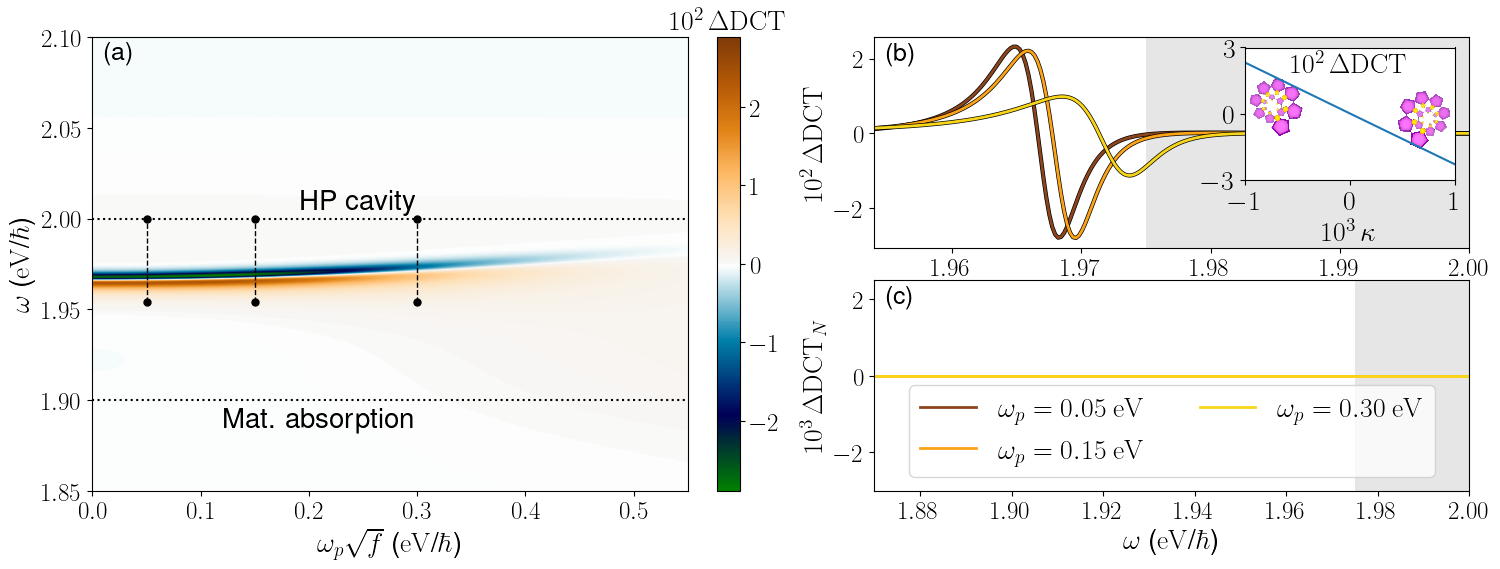

In [11]:
fig, axs = plt.subplot_mosaic("""ab
                                 ac""",layout="constrained",figsize=(15,5.5))

axs["a"].tick_params(axis='both', which='major', labelsize=18)
axs["b"].tick_params(axis='both', which='major', labelsize=18)
axs["c"].tick_params(axis='both', which='major', labelsize=18)

plt.rcParams.update({ "text.usetex": True, "font.family": "Helvetica"})
ax = axs["a"]
vmax = 100*abs(S_HP.ΔDCTs).max()
im = ax.pcolormesh(omegap, omega, 100*S_HP.ΔDCTs, cmap='oceanPu',vmin=-vmax, vmax=vmax, shading='gouraud', zorder=-2, rasterized=True)
cb = plt.colorbar(im, ax=ax)
cb.ax.tick_params(labelsize=18)
cb.ax.set_title(r'$10^2\,\Delta\mathrm{DCT}$',fontsize=20)
for yval in 1.9, 2:
    ax.axhline(yval,ls=":",color="k",lw=1.5)
ax.text(0.3,2.005,"HP cavity",ha="right", fontsize=20)
ax.text(0.3,1.885,"Mat. absorption",ha="right", fontsize=20)
ax.set_xlabel(r"$\omega_p \sqrt{f}$ ($\mathrm{eV}$/$\hbar$)", fontsize=20)
ax.set_ylabel(r"$\omega$ ($\mathrm{eV}$/$\hbar$)",fontsize=20)
ax.set_xlim(0,0.55)
ax.set_ylim(1.85,2.1)

for omegapcut,color in [(0.05,'#8b441b'), (0.15,'#fca318'), (0.3,'#f9d61a')]:
    icut = np.argmin(abs(omegap-omegapcut))
    axs["b"].plot(omega.squeeze(), 1e2*S_HP.ΔDCTs[:,icut], color="k",   lw=3)
    axs["b"].plot(omega.squeeze(), 1e2*S_HP.ΔDCTs[:,icut], color=color, lw=2)
    #axs["c"].plot(omega.squeeze(), 1e4*S_Ag.ΔDCTs[:,icut], color="k",   lw=3)
    axs["c"].plot(omega.squeeze(), 1e3*S_Ag.ΔDCTs[:,icut], color=color, lw=2, label=r'$\omega_p = %.2f$ $\mathrm{eV}$' % omegapcut)
    axs["a"].plot([omegapcut,omegapcut],[1.954,2],'ko--',ms=5,lw=1)
    axs["c"].set_xlim(1.87,2)

axs["b"].set_xlim(1.954,2)
axs["c"].set_xlim(1.87,2)
axs["c"].set_ylim(-3,2.5)
axs["b"].set_ylabel(r'$10^2\,\Delta\mathrm{DCT}$',fontsize=20)
axs["c"].set_ylabel(r'$10^3\,\Delta\mathrm{DCT}_{N}$',fontsize=20)
axs["c"].set_xlabel(r'$\omega$ ($\mathrm{eV}$/$\hbar$)',fontsize=20)
for ax in axs["b"], axs["c"]:
    y1,y2 = ax.get_ylim()
    ax.add_patch(Rectangle((1.975, y1), 2-1.975, y2-y1, facecolor="0.9"))

axs["c"].legend(loc="lower center", fontsize=20, ncol = 2)

fig.get_layout_engine().set(w_pad=0.1, h_pad=0, hspace=0.0, wspace=0.0)
fig.get_layout_engine().execute(fig)
fig.set_layout_engine(None)

ax = fig.add_axes((0.83,0.69,0.14,0.24))
ax.plot(1e3*S_kappascan.kappa,1e2*S_kappascan.ΔDCTs)
ax.autoscale(axis="x",tight=True)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_yticks([-3,0,3])
for ii in range(1,3):
    im = plt.imread(f"chiral_molecule_{ii}.png")
    ab = AnnotationBbox(OffsetImage(im, zoom=0.07), (0.7, -0.3) if ii==2 else (-0.7,0.3),
                        frameon=False, zorder=-1)
    ax.add_artist(ab)
ax.set_xlabel(r"$10^3\,\kappa$", fontsize=20)
ax.set_title(r'$10^2\,\Delta\mathrm{DCT}$',y=0.75,fontsize=20)
for lab in "abc":
    axs[lab].text(0.02,0.95 if lab=="a" else 0.89,f"({lab})",transform=axs[lab].transAxes,fontsize=18)
fig.align_ylabels([axs["b"],axs["c"]])
#fig.savefig("Fig4_kConst_L130.pdf", bbox_inches='tight')